In [1]:
import zipfile
import os

zip_path = "/content/Project10.zip"
extract_path = "/content/Project10"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List files
print("📂 Extracted files:")
print(os.listdir(extract_path))


📂 Extracted files:
['MiningProcess_Flotation_Plant_Database.csv']


In [2]:
import pandas as pd

# Correct file path
file_path = "/content/Project10/MiningProcess_Flotation_Plant_Database.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
df.head()


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


In [3]:
df = df.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
df = df.astype(float, errors='ignore')
df['date'] = pd.to_datetime(df['date'])
df.isnull().sum()
df = df.dropna()  # or df.fillna(method='ffill')


/tmp/ipython-input-3-2640030540.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)


In [4]:
# Replace commas with dots in the entire DataFrame (only for object/string columns)
df = df.replace(',', '.', regex=True)

# Convert all numeric-looking columns to float where possible
df = df.apply(pd.to_numeric, errors='ignore')

df['date'] = pd.to_datetime(df['date'])


/tmp/ipython-input-4-1261055799.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [5]:
# Replace commas with dots in the entire DataFrame (only for object/string columns)
df = df.replace(',', '.', regex=True)

# Convert all numeric-looking columns to float where possible
df = df.apply(pd.to_numeric, errors='ignore')

df['date'] = pd.to_datetime(df['date'])


/tmp/ipython-input-5-1261055799.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


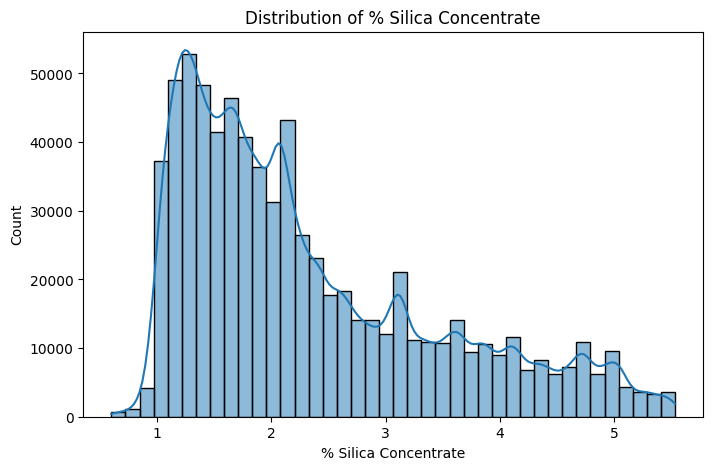

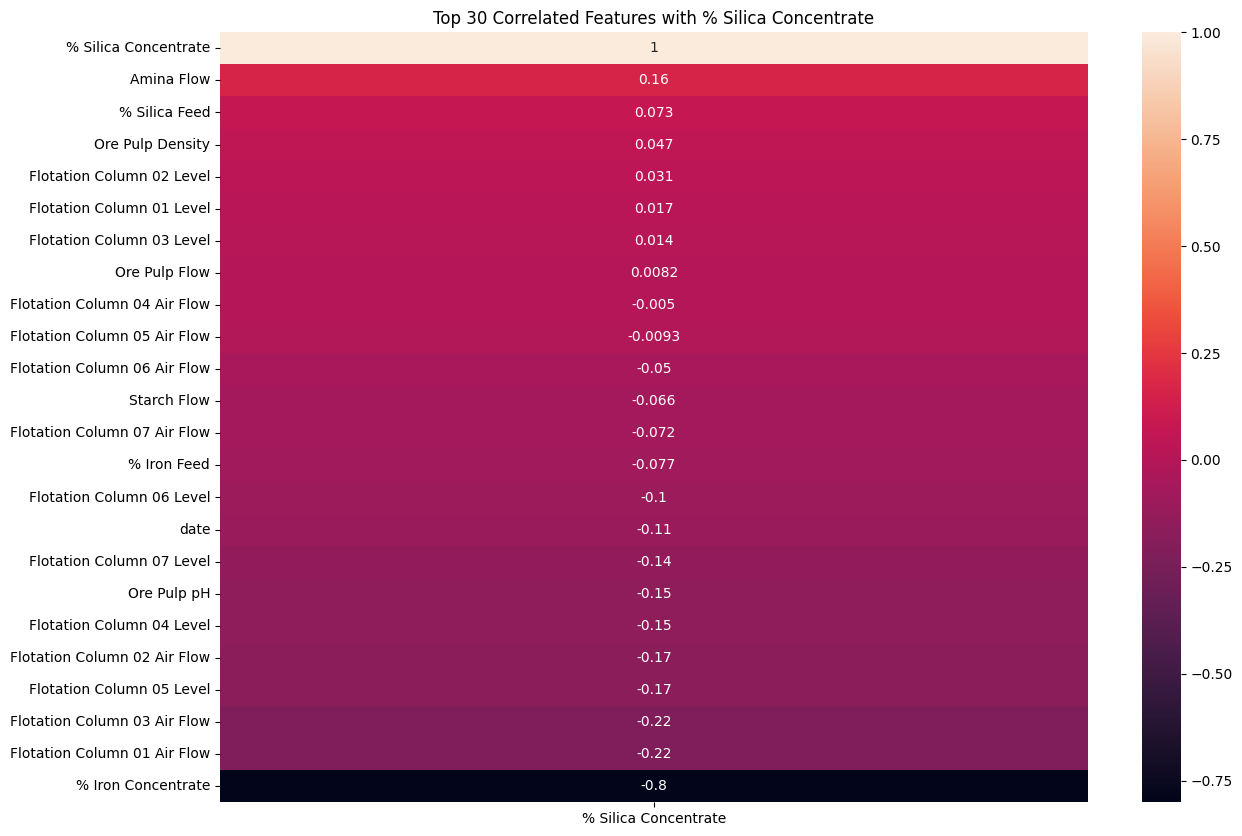

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize target distribution
plt.figure(figsize=(8,5))
sns.histplot(df['% Silica Concentrate'], kde=True, bins=40)
plt.title("Distribution of % Silica Concentrate")
plt.show()

# Correlation heatmap (top variables)
plt.figure(figsize=(14,10))
corr = df.corr()
sns.heatmap(corr.tail(1).T.sort_values('% Silica Concentrate', ascending=False).head(30), annot=True)
plt.title("Top 30 Correlated Features with % Silica Concentrate")
plt.show()


In [7]:
# Drop if you're testing without Iron Concentrate
df = df.drop(columns=["% Iron Concentrate"])


In [13]:
!pip install xgboost


In [15]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Feature + Target Setup
X = df.drop(columns=["% Silica Concentrate", "date"])
X = X.select_dtypes(include='number')  # Keep only numeric features
y = df["% Silica Concentrate"]

# Clean NaNs/Infs
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
y = y[X.index]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))

print("✅ R² Score:", round(r2, 4))
print("✅ RMSE:", round(rmse, 4))


✅ R² Score: 0.6886
✅ RMSE: 0.6273
